Code for the ViT model and visualizing attention maps

In [ ]:
import torch
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
import math
import copy

# All the parameters for the code
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 32
IN_CHANNELS = 3
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 64

# Device setup
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

# Model Defining
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim,
                 dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x, oa):
        x = self.embeddings_block(x)
        # Get attention maps from the first layer of the encoder
        _, attention_maps = self.encoder_blocks.layers[0].self_attn(x, x, x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        if oa:
            return x, attention_maps
        else :
            return x
# Model instantiation
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)

# Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Lists to store accuracy values during training and evaluation
model_train_accuracy = []
model_test_accuracy = []

# Function to train the model
def train_model(model, criterion, optimizer, train_accuracy_list, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        correct_predictions = 0
        total_predictions = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, oa = False)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Track training accuracy
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

        train_accuracy = correct_predictions / total_predictions
        train_accuracy_list.append(train_accuracy)
        progress_bar.close()

        # Evaluation on the validation set
        model.eval()
        correct_predictions = 0
        total_predictions = 0
        class_correct = torch.zeros(10)
        class_total = torch.zeros(10)
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, oa = False)
                _, preds = torch.max(outputs, 1)
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)

                c = (preds == labels).squeeze()
                for i in range(10):
                  label = labels[i]
                  class_correct[label] += c[i].item()
                  class_total[label] += 1

        test_accuracy = correct_predictions / total_predictions
        model_test_accuracy.append(test_accuracy)

        # Print class-wise accuracy
        for i in range(10):
          accuracy = (class_correct[i] / class_total[i]) * 100 if class_total[i] != 0 else 0
          print(f"Class {i} Accuracy: {accuracy}%")

        # Print overall accuracy
        overall_accuracy = (correct_predictions / total_predictions) * 100
        print(f"Overall Test Accuracy: {overall_accuracy}%")

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

# Training the model
train_model(model, criterion, optimizer, model_train_accuracy, EPOCHS)

# Attention maps
# Setting model to evaluation mode
model.eval()

# Loading random images
num_images = 4
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Picking samples randomly
indices = torch.randperm(len(testset))[:num_images]
raw_images = [np.asarray(testset[i][0]) for i in indices]
labels = [testset[i][1] for i in indices]

# Converting the images to tensors
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
images = torch.stack([test_transform(image) for image in raw_images])

# Move the images to the device
images = images.to(device)
model = model.to(device)
logits, attention_maps = model(images, oa = True)
predictions = torch.argmax(logits, dim=1)
attention_maps = attention_maps.unsqueeze(1)
attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
attention_maps = attention_maps.squeeze(1)
fig = plt.figure(figsize=(20, 10))
mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)

# Plotting the attention maps
for i in range(num_images):
        ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].detach().cpu().numpy()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))

plt.savefig("attention_map")
plt.show()


This is the result of the model after training it for 10 epochs

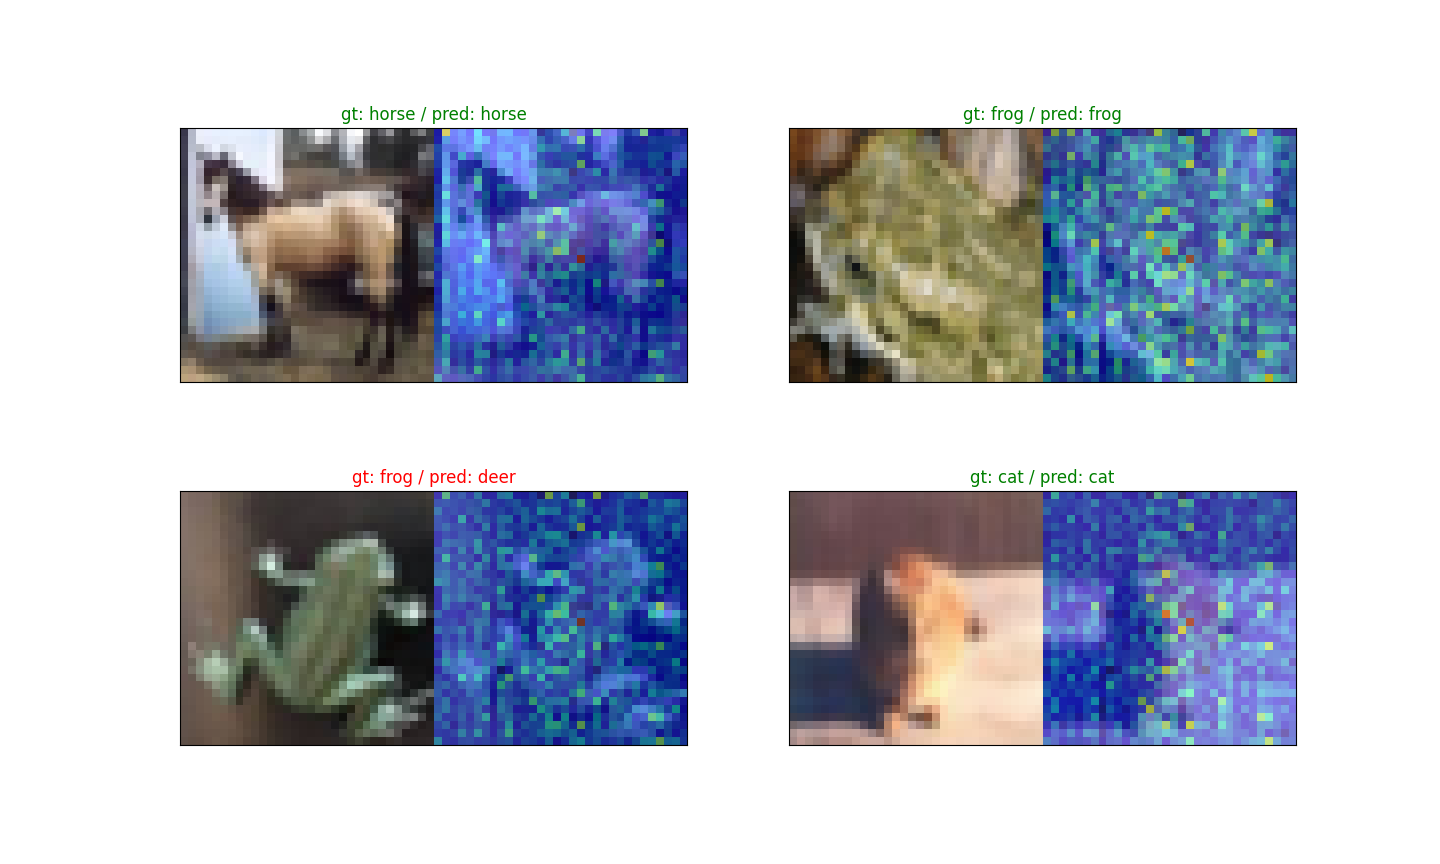